In [1]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

In [2]:
plt.rcParams["font.family"] = "Linux Libertine O"
plt.rcParams["font.size"] = 40

## Full Dataset

In [3]:
protocols = np.array([59, 60, 82, 88, 89, 90, 95, 110, 123, 140, 156, 168, 180, 186, 201, 203, 208, 212, 225, 226, 241, 248])

In [ ]:
# We need to read data and transform the time column into datetime object
files = ['<sensor_id>']

data = pd.DataFrame()
for f in files:
    df = pd.read_csv(f"../data/tpms-{f}.csv")
    df["time"] = pd.to_datetime(df["time"])
    df.set_index(["time"], inplace=True)
    df = df[df["protocol"].isin(protocols)]
    df['sensor'] = f
    if data.empty:
        data = df
    else:
        data = pd.concat((data,df))

In [5]:
cars = pd.read_csv('../data/cars.csv')
cars_np = cars[['id1','id2','id3','id4','id5','id6','id7','id8']].to_numpy(dtype=str).flatten()
cars_np = cars_np[~(cars_np == 'nan')]

In [6]:
brands = np.array(['Ford','Jansite','Schrader','Toyota','Schrader-EG53MA4','Hyunday-VDO','Renault'])
brands_shortened = {'Ford': 'F','Jansite': 'J','Schrader': 'S', 'Toyota': 'T', 'Schrader-EG53MA4': 'S2','Hyunday-VDO': 'H','Renault': 'R'}

In [7]:
data = data[data['car'].isin(brands)]
data['short'] = data['car'].apply(lambda x: brands_shortened[x])

## Total car counts

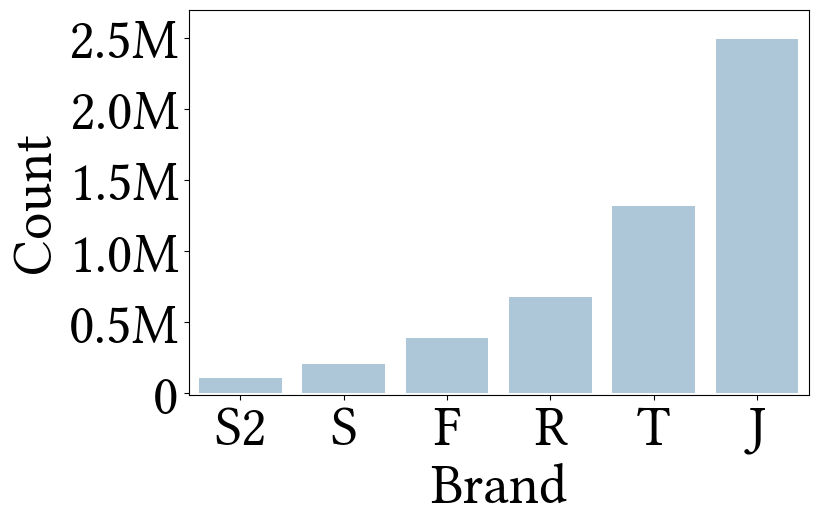

In [16]:
f, ax = plt.subplots(figsize=(8, 5))
ax = sns.countplot(x="short", 
                  #  palette="flare", 
                   data=data, 
                   order=data["short"].value_counts(ascending=True).index, 
                   alpha=.4,
                   ax=ax
                )
# ax.bar_label(ax.containers[0])

# Format Data
ax.set_xlabel("Brand")
ax.set_ylabel("Count")

## Rotate xlabel
ax.tick_params(axis='x', rotation=0)

## Use thousands separator for y labels
ax.set(ylim = (-10000,2700000))
ax.set_yticks([0, 500000, 1000000, 1500000, 2000000, 2500000])
ylabels = [f'{x}M' for x in ax.get_yticks().astype(int)/1000000]
ylabels[0] = '0'
ax.set_yticklabels(ylabels)

plt.savefig('../pics/dataset/allcars.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Unique counts

In [17]:
groups_sm = data.groupby(['short']).size().reset_index(name='counts')
unique  = data.drop_duplicates(subset=['id'], keep='first')
unique_sm = unique.groupby(['short']).size().reset_index(name='counts')

compare = pd.merge(groups_sm, unique_sm, left_index=True, right_index=True)

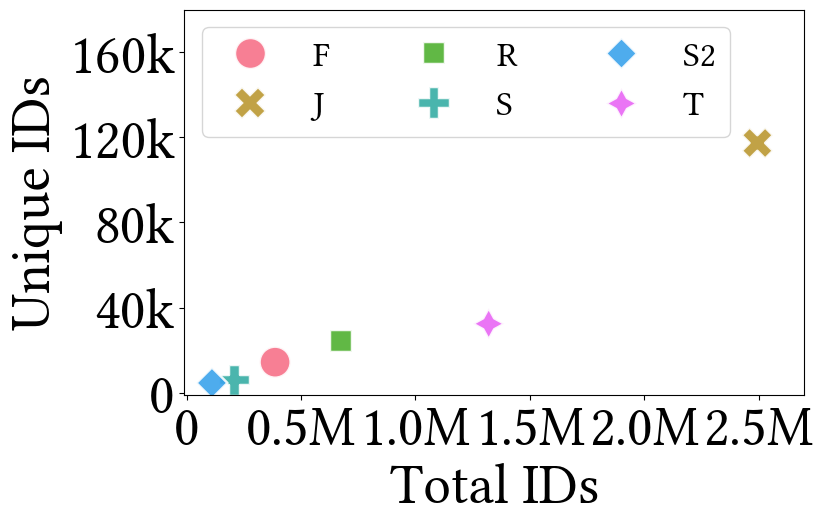

In [30]:
p = sns.color_palette("husl", 6)
markers = ['']
f, ax = plt.subplots(figsize=(8, 5))
# sns.set(font_scale=2)
ax = sns.scatterplot(x="counts_x",
                   y="counts_y",
                  #  palette="flare",
                   hue="short_x",
                   style="short_x",
                   data=compare,
                   palette=p,
                   alpha=0.9,
                   s=500,
                   ax=ax
                )
# ax.bar_label(ax.containers[0])

# Format Data
ax.set_xlabel("Total IDs")
ax.set_ylabel("Unique IDs")

plt.legend(ncol=3, loc='upper left',fontsize=25)
# ## Rotate xlabel
# ax.tick_params(axis='x', rotation=25)
# ## Use thousands separator for x & y labels
# ax.set(ylim = (0,300000))
ax.set_xlim([-10000,2700000])
ax.set_xticks(np.arange(0,3000000,500000))
xlabels = [f'{x}M' for x in ax.get_xticks().astype(int)/1000000]
xlabels[0] = '0'
ax.set_xticklabels(xlabels)

ax.set_ylim([-1000,180000])
ax.set_yticks(np.arange(0,200000,40000))
ylabels = [f'{x}k' for x in ax.get_yticks().astype(int)//1000]
ylabels[0] = '0'
ax.set_yticklabels(ylabels)

plt.savefig('../pics/dataset/totalvsunique.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Distribution by sensor

In [31]:
change = {'auditorium': 'S.1', 'electrosenselab': 'S.2', 'marconi': 'S.3', 'nicasio': 'S.4', 'office': 'S.5'}
data['sensorsh'] = data['sensor'].apply(lambda x: change[x])

In [32]:
agg = data.groupby(by=[pd.Grouper(freq='4H'),'sensorsh']).size().unstack(fill_value=-1)
agg[agg > 0] = 1

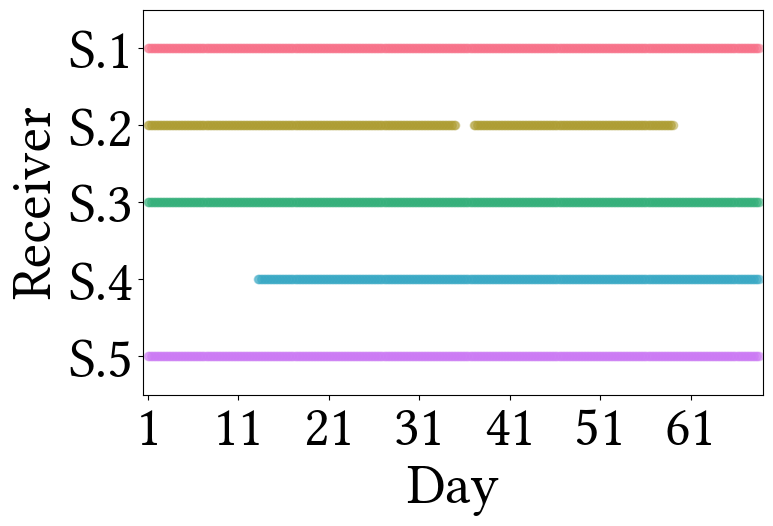

In [42]:
length = np.arange(agg.shape[0])
p = sns.color_palette("husl", 5)
f, ax = plt.subplots(figsize=(8, 5))

ax.scatter(length, 5*agg['S.1'], alpha=.4, color=p[0])
ax.scatter(length, 4*agg['S.2'], alpha=.4, color=p[1])
ax.scatter(length, 3*agg['S.3'], alpha=.4, color=p[2])
ax.scatter(length, 2*agg['S.4'], alpha=.4, color=p[3])
ax.scatter(length, 1*agg['S.5'], alpha=.4, color=p[4])

# Define the date format
ax.set_xticks(np.arange(0,68*24//4,24*10//4))
xt = ax.get_xticklabels()
ax.set_xticklabels(["{}".format(i*10 + 1) for (i,_) in enumerate(xt)])

# Format Data
ax.set_xlabel("Day")
ax.set_ylabel("Receiver")
# ## Rotate xlabel
ax.set_xlim([-0.5*6,68.*6])
ax.set_ylim([0.5, 5.5])
ax.set_yticks([1,2,3,4,5])
ax.set_yticklabels(['S.5','S.4','S.3','S.2','S.1'])

plt.savefig('../pics/dataset/availability.pdf',format='pdf',bbox_inches='tight')
plt.show()

## Distribution of IDs per sensor

In [43]:
sums_df = data.groupby(['short']).count().reset_index()[['short','id']]
counts_df = data.groupby(['short','sensorsh']).count().reset_index()[['short','sensorsh','id']]
order = np.array(['S.1','S.2','S.3','S.4','S.5'])

In [44]:
plot_df = sums_df.copy()
for (index,name,qty) in plot_df.itertuples():
    tmp_df = counts_df[counts_df['short']==name]
    for sensor in order:
        try:
            qtys = tmp_df[tmp_df['sensorsh'] == sensor]['id'].item()
        except:
            qtys = 0
        plot_df.loc[index,sensor] = qtys/qty

plot_df = plot_df.drop(['id'],axis=1)

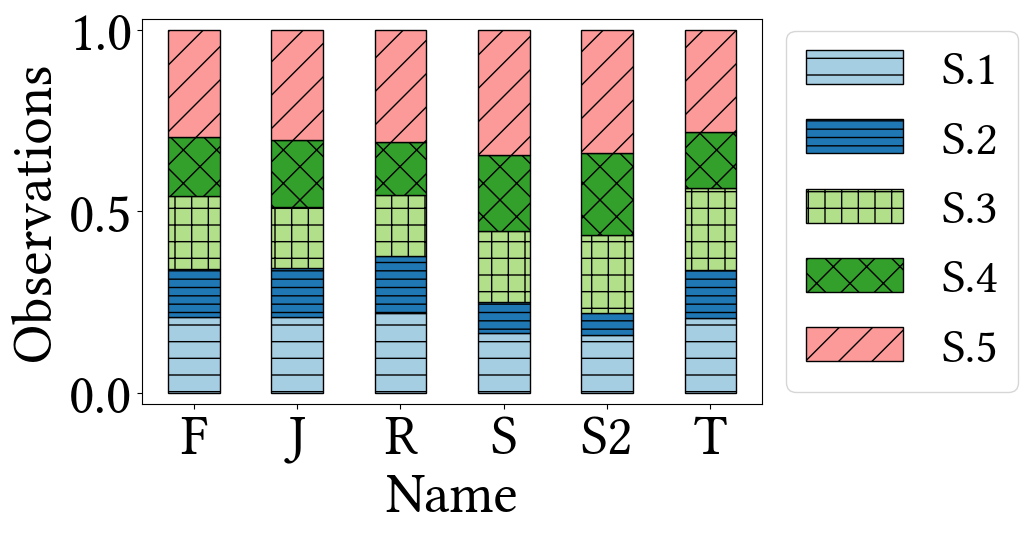

In [46]:
f, ax = plt.subplots(figsize=(8, 5))
p = sns.color_palette("Paired", 9)
plot_df.plot.bar(x='short',stacked=True, color=p, ax=ax)

# Format Data
ax.set_xlabel("")
ax.set_ylabel("")

bars = ax.patches
patterns =('-', '--', '+', 'x','/','//','+-','\\','\\\\')
hatches = [p for p in patterns for i in range(len(plot_df))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)
    bar.set_edgecolor('black')

plt.legend(markerscale=2,loc='center left',bbox_to_anchor=(1,0.5),fontsize=35)
# ## Rotate xlabel
ax.tick_params(axis='x', rotation=0)
ax.set_xlabel('Name')
# ## Use thousands separator for x & y labels
ax.set(ylim = (-0.03,1.03))
ax.set_ylabel('Observations')
# xlabels = [f'{x}k' for x in ax.get_xticks().astype(int)//1000]
# xlabels[1] = '0'
# ax.set_xticklabels(xlabels)
# ylabels = [f'{x}k' for x in ax.get_yticks().astype(int)//1000]
# ylabels[1] = '0'
# ax.set_yticklabels(ylabels)
# plt.show()
plt.savefig('../pics/dataset/branddistribution.pdf', format='pdf', bbox_inches='tight')
plt.show()